# XCB Generator (https://mastane.github.io/posts/2023/10/blog-post-1/)

## Apply Lemma 1 in: https://arxiv.org/abs/2309.15298
* Given log-concave function $p$ 
* Compute cross-convex function $F(x,y)=-\log(p(x)+p(y))$ 
* Tangent lower bound $\mathcal{T}_{a,b}(x, y) = F(a,b) + \nabla F(a,b)^\top \begin{pmatrix} x-a \\ y-b \end{pmatrix} - D_{\text{KL}}\left( \begin{pmatrix} \frac{p(a)}{p(a)+p(b)} \\ \frac{p(b)}{p(a)+p(b)} \end{pmatrix} \, \Bigg\| \, \begin{pmatrix} \frac{p(x)}{p(x)+p(y)} \\ \frac{p(y)}{p(x)+p(y)} \end{pmatrix} \right)$

In [1]:
!pip install ipywidgets


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [3]:
def F(p, x, y):
    """
    - given p(x): log-concave function
    -> return F(x,y): cross-convex function
    """
    return -np.log( p(x) + p(y) )

def dF(p, dp, x, y):
    """
    - given p(x): log-concave function
    - given dp(x): derivative of p
    -> return gradient of F at (x,y)
    """
    return -np.array( [ dp(x), dp(y) ] ) / ( p(x) + p(y) )

def KL(p, a, b, x, y):
    """
    - given p(x): log-concave function
    -> compute KL divergence between distributions generated by (a,b) & (x,y)
    """
    # binary distribution at (a,b)
    p1 = p(a)/(p(a) +p(b))
    p2 = p(b)/(p(a) +p(b))
    # binary distribution at (x,y)
    q1 = p(x)/(p(x) +p(y))
    q2 = p(y)/(p(x) +p(y))
    return p1*np.log(p1/q1) + p2*np.log(p2/q2)

def tangent_surface(p, dp, x, y, a, b):
    """
    - given tangent point (a,b)
    - given p: log-concave function
    - given dp: derivative of p
    -> return tangent surface below F (see Lemma 1 in: https://arxiv.org/abs/2309.15298)
    """
    return F(p, a, b) + ( dF(p, dp, a, b)[:,None,None] * np.array( [x - a, y - b] ) ).sum(axis=0) - KL(p, a, b, x, y)

In [4]:
import ipywidgets as widgets
from IPython.display import display
import sympy as sp
from sympy import lambdify

z = sp.symbols('z')

# Define the log-concave functions and their derivatives
functions = {
    'Gaussian': (1/sp.sqrt(2*sp.pi)) * sp.exp(-z**2/2),
    'Logistic': sp.exp(-z)/(1 + sp.exp(-z))**2,
    'Sech': (1/(2*sp.pi)) * 1/sp.cosh(z),
    'Gumbel': sp.exp(-z - sp.exp(-z)),
}

# Compute the derivatives
derivatives = {name: sp.diff(func, z) for name, func in functions.items()}

# These variables will hold the chosen function, its derivative, and its name
p = None
dp = None
name = None

# Create the dropdown menu
dropdown = widgets.Dropdown(
    options=functions.keys(),
    description='Function:',
    disabled=False,
)

# This function will be called whenever the dropdown value changes
def on_change(change):
    global p, dp, name
    if change['type'] == 'change' and change['name'] == 'value':
        name = change['new']
        symbolic_p = functions[name]
        p = lambdify(z, symbolic_p, 'numpy')
        symbolic_dp = derivatives[name]
        dp = lambdify(z, symbolic_dp, 'numpy')

dropdown.observe(on_change)
display(dropdown)

# Manually initialize the functions for the initial dropdown value ("Gaussian")
on_change({'type': 'change', 'name': 'value', 'new': dropdown.value})

Dropdown(description='Function:', options=('Gaussian', 'Logistic', 'Sech', 'Gumbel'), value='Gaussian')

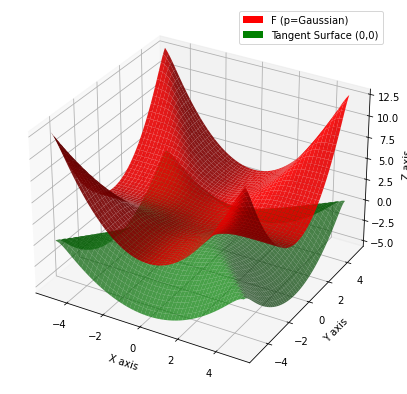

<Figure size 432x288 with 0 Axes>

In [5]:
# Define the tangent point (a, b)
a, b = 0, 0
zoom = False
if name=='Gumbel':
    zoom = True
colorF = 'r'  #'darkmagenta' 'darkorchid' 'magenta' 'skyblue' 'r'
colorT = 'g'  #'r' 'g' (color of tangent surface)
#colorP = 'k'  #'b' 'k' 'y' (color of tangent point)

# Create a meshgrid for plotting
if zoom:
    xs = np.linspace(-1.5, 1.5, 400)
    ys = np.linspace(-1.5, 1.5, 400)
else:
    xs = np.linspace(-5, 5, 1000)
    ys = np.linspace(-5, 5, 1000)

# Grid
X, Y = np.meshgrid(xs, ys)
Z = F(p, X, Y)
T = tangent_surface(p, dp, X, Y, a, b)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot surfaces
if zoom:
    ax.plot_surface(X, Y, Z, alpha=0.9, rstride=20, cstride=20, color=colorF, label='F (p={})'.format(name))
    ax.plot_surface(X, Y, T, alpha=0.7, rstride=20, cstride=20, color=colorT, label='Tangent Surface ({},{})'.format(a,b))
else:
    ax.plot_surface(X, Y, Z, alpha=0.9, rstride=20, cstride=20, color=colorF, label='F (p={})'.format(name))
    ax.plot_surface(X, Y, T, alpha=0.7, rstride=20, cstride=20, color=colorT, label='Tangent Surface ({},{})'.format(a,b))

# Highlight the tangent point
#ax.scatter([a], [b], [F(p,a, b)], color=colorP, s=100, marker='o', label='Tangent Point ({},{})'.format(a,b))

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
#ax.set_title("Cross-convex function F (p={}) and its tangent surface at ({},{})".format(name,a,b))

# Creating a legend for the surfaces.
surf1 = plt.Rectangle((0, 0), 1, 1, fc=colorF, edgecolor='none')
surf2 = plt.Rectangle((0, 0), 1, 1, fc=colorT, edgecolor='none')
#tangent_point = plt.Line2D([0], [0], linestyle="none", c=colorP, marker='o')
#ax.legend([surf1, surf2, tangent_point], ['F (p={})'.format(name), 'Tangent Surface', 'Tangent Point ({},{})'.format(a,b)], loc='upper right')
ax.legend([surf1, surf2], ['F (p={})'.format(name), 'Tangent Surface ({},{})'.format(a,b)], loc='upper right')

plt.show()
fig.savefig('images/tangent_{}{}_{}.png'.format(a,b,name), dpi=300)

# Rotation function
def update(num):
    ax.view_init(30, 2*num)
    plt.draw()
    return fig,

ani = animation.FuncAnimation(fig, update, frames=180, interval=100)

# Save the animation as a GIF
ani.save('gifs/rotating_plot_{}{}_{}.gif'.format(a,b,name), writer='imagemagick')